In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = r"D:\SPOORTHI\Herlev DataSet\Processed_Data\filtered_images"
batch_size = 32
num_classes = 7  # Number of classes (7 directories)

# Step 1: Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for SqueezeNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the entire dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Split into train and validation sets (70%, 30%)
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = len(dataset) - train_size  # Remaining 30% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # No shuffle for validation


In [2]:
# Step 2: Define SqueezeNet Model
class CustomSqueezeNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomSqueezeNet, self).__init__()
        self.model = models.squeezenet1_1(pretrained=True)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

model = CustomSqueezeNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Govindu Vijay Kumar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Govindu Vijay Kumar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomSqueezeNet(
  (model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

In [3]:
class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1):
        defaults = dict(lr=lr, momentum=momentum, exploration_factor=exploration_factor)
        super(GazelleOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            momentum = group['momentum']
            lr = group['lr']
            exploration_factor = group['exploration_factor']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Add exploration (random perturbation scaled by exploration_factor)
                exploration = torch.randn_like(d_p) * exploration_factor
                
                if 'momentum_buffer' not in self.state[p]:
                    self.state[p]['momentum_buffer'] = torch.clone(d_p).detach()
                else:
                    buf = self.state[p]['momentum_buffer']
                    buf.mul_(momentum).add_(d_p)
                    d_p = buf

                # Update parameters with exploration
                p.data.add_(-lr, d_p + exploration)

        return loss
        # Instantiate the optimizer
optimizer = GazelleOptimizer(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
# Step 4: Define Loss and Training Loop
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [9]:
# Initialize lists to track accuracy and loss
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    # Store losses and accuracies for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate the final model on the test set
test_loss, test_acc, _, _ = evaluate(model, val_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")




C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_8680\3160225206.py:32: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1642.)
  p.data.add_(-lr, d_p + exploration)


Epoch 1/20
Train Loss: 1.7067, Train Acc: 0.3198
Val Loss: 1.7564, Val Acc: 0.3696
Epoch 2/20
Train Loss: 1.3460, Train Acc: 0.4696
Val Loss: 2.1046, Val Acc: 0.3841
Epoch 3/20
Train Loss: 1.5701, Train Acc: 0.4181
Val Loss: 2.0487, Val Acc: 0.2899
Epoch 4/20
Train Loss: 1.4579, Train Acc: 0.4446
Val Loss: 1.3037, Val Acc: 0.4891
Epoch 5/20
Train Loss: 1.0962, Train Acc: 0.5741
Val Loss: 1.1660, Val Acc: 0.5326
Epoch 6/20
Train Loss: 1.0363, Train Acc: 0.5897
Val Loss: 1.0741, Val Acc: 0.5870
Epoch 7/20
Train Loss: 1.0321, Train Acc: 0.5975
Val Loss: 1.1462, Val Acc: 0.5652
Epoch 8/20
Train Loss: 1.0532, Train Acc: 0.5866
Val Loss: 1.0571, Val Acc: 0.5435
Epoch 9/20
Train Loss: 0.9005, Train Acc: 0.6381
Val Loss: 1.0521, Val Acc: 0.5942
Epoch 10/20
Train Loss: 0.9146, Train Acc: 0.6131
Val Loss: 1.4736, Val Acc: 0.4674
Epoch 11/20
Train Loss: 0.9822, Train Acc: 0.6147
Val Loss: 1.0674, Val Acc: 0.5507
Epoch 12/20
Train Loss: 0.8663, Train Acc: 0.6537
Val Loss: 2.3163, Val Acc: 0.4493
E

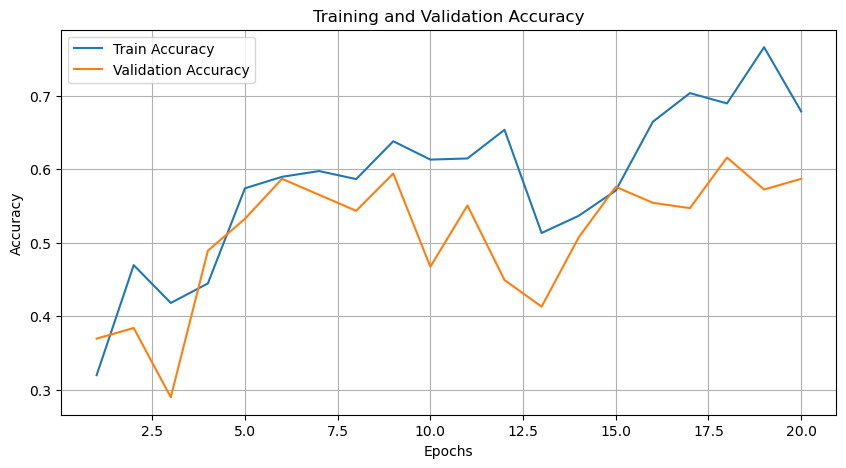

In [10]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


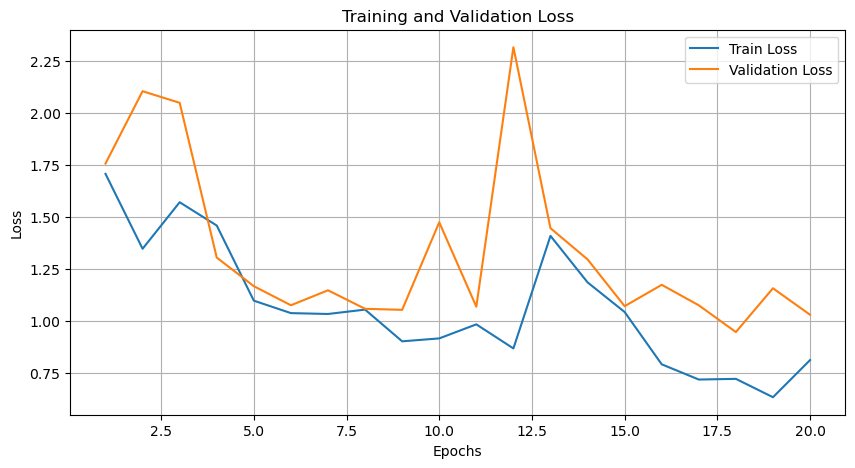

In [11]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.5870
Precision: 0.5956
Recall: 0.5870
F1 Score: 0.5829
MCC: 0.5034


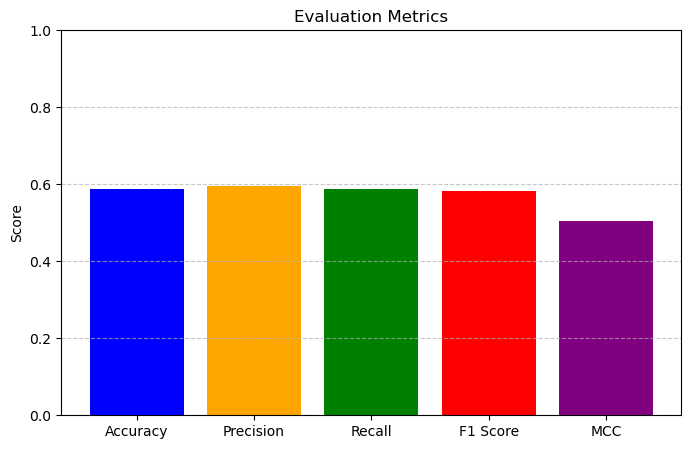

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Compute metrics
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for class imbalance
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    return accuracy, precision, recall, f1, mcc

# Evaluate the model to get predictions and labels
_, _, all_preds, all_labels = evaluate(model, val_loader, criterion)

# Compute metrics
accuracy, precision, recall, f1, mcc = compute_metrics(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC']
values = [accuracy, precision, recall, f1, mcc]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1)  # All metrics range between 0 and 1
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

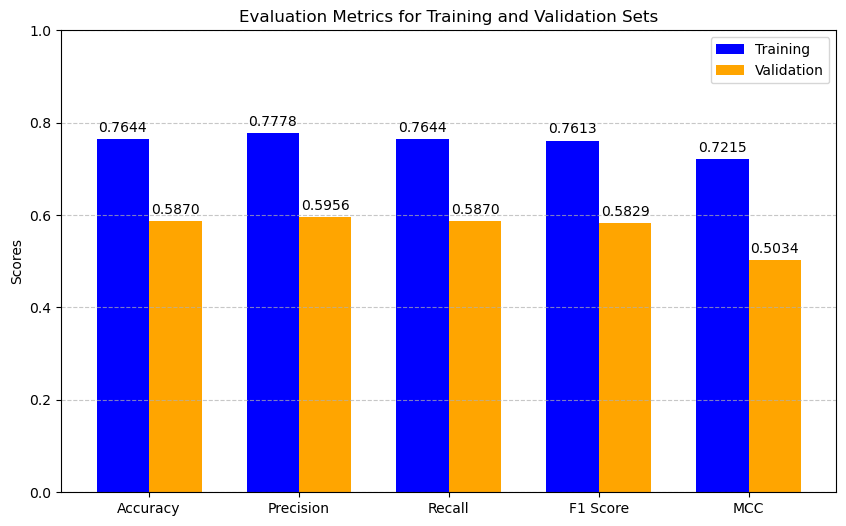

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Function to compute metrics for a given set of labels and predictions
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for class imbalance
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    return accuracy, precision, recall, f1, mcc

# Evaluate the model on the training set to get predictions and labels
_, _, train_preds, train_labels = evaluate(model, train_loader, criterion)

# Compute metrics for training and validation/testing sets
train_metrics = compute_metrics(train_labels, train_preds)
val_metrics = compute_metrics(all_labels, all_preds)  # Already computed earlier

# Plot the metrics for both sets
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC']
train_values = train_metrics
val_values = val_metrics

# Create a grouped bar plot
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for training and validation/testing metrics
train_bars = ax.bar(x - width/2, train_values, width, label='Training', color='blue')
val_bars = ax.bar(x + width/2, val_values, width, label='Validation', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Training and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with the actual values
for bar in train_bars + val_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points
                textcoords="offset points",
                ha='center', va='bottom')

# Display the plot
plt.ylim(0, 1)  # Since all metrics range between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 1000x800 with 0 Axes>

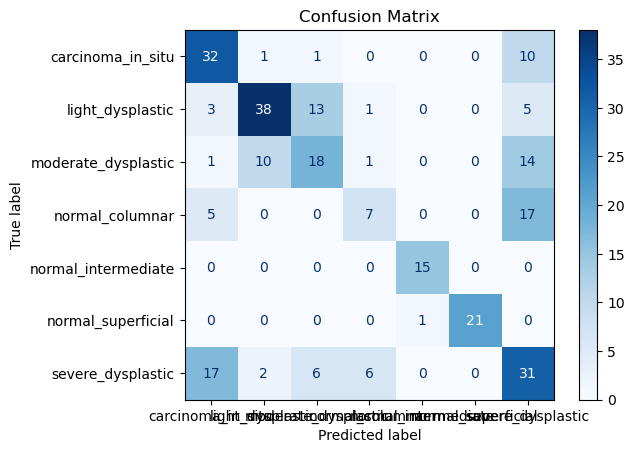

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()



<Figure size 1000x800 with 0 Axes>

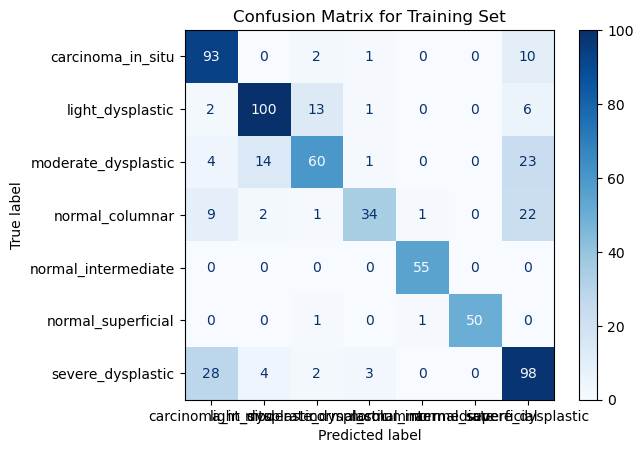

<Figure size 1000x800 with 0 Axes>

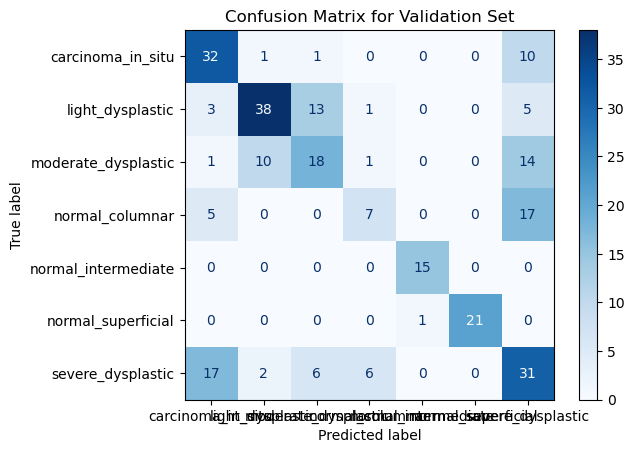

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

# Plot confusion matrix for training set
plot_confusion_matrix(train_labels, train_preds, dataset.classes, title="Confusion Matrix for Training Set")

# Plot confusion matrix for validation/testing set
plot_confusion_matrix(all_labels, all_preds, dataset.classes, title="Confusion Matrix for Validation Set")


In [14]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=dataset.classes)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.55      0.73      0.63        44
   light_dysplastic       0.75      0.63      0.68        60
moderate_dysplastic       0.47      0.41      0.44        44
    normal_columnar       0.47      0.24      0.32        29
normal_intermediate       0.94      1.00      0.97        15
 normal_superficial       1.00      0.95      0.98        22
  severe_dysplastic       0.40      0.50      0.45        62

           accuracy                           0.59       276
          macro avg       0.65      0.64      0.64       276
       weighted avg       0.60      0.59      0.58       276



In [15]:
from PIL import Image

# Function to classify a single image
def classify_image(image_path, model, transform, class_names):
    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
    # Apply transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    # Move the tensor to the device (CPU or GPU)
    input_tensor = input_tensor.to(device)
    
    # Predict using the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)  # Get the index of the highest score
    
    # Get the class name
    predicted_label = class_names[predicted_class.item()]
    return predicted_label

# Path to the image to be classified
image_path = r"D:/SPOORTHI/Herlev DataSet/Processed_Data/filtered_images/moderate_dysplastic/filtered_149014929-149014994-001.bmp"

# Predict the class
predicted_label = classify_image(image_path, model, transform, dataset.classes)

# Display the result
print(f"The image is classified as: {predicted_label}")


The image is classified as: light_dysplastic


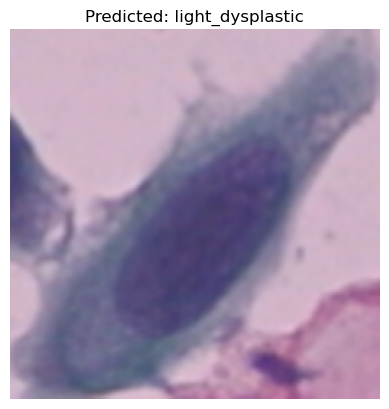

In [16]:
import matplotlib.pyplot as plt

# Display the image with the predicted label
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


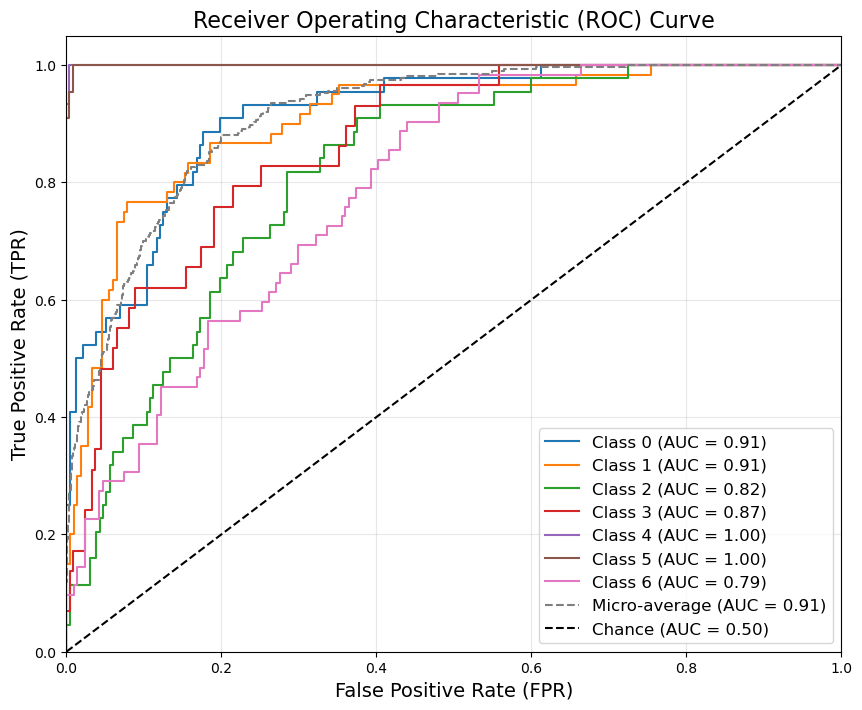

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming num_classes, val_loader, and model are defined
model.eval()
all_labels = []
all_probs = []

# Compute probabilities and true labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probabilities)
        all_labels.extend(labels.cpu().numpy())

# Convert labels to one-hot encoding for multi-class ROC
all_labels_onehot = label_binarize(all_labels, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_onehot.ravel(), np.array(all_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()
